## Aplicación de Time-Dependent DIP desde datos listos en numpy
- Autor: Tabita Catalán
- Creación: 2024
- Actualización: Comentarios en códigos por Evelyn Cueva

In [2]:
import numpy as onp 
import matplotlib.pyplot as plt 
from inrmri.image_processor import reduce_FOV
from inrmri.basic_plotting import full_halph_FOV_space_time

# folder = '/data/Josefa-CineLR/'
folder = 'C:\\Users\\Legion\\OneDrive - Escuela Politécnica Nacional\\Postdoc_iHealth\\ST-DIP-SR\\repositories\\NF-cMRI\\data\\Josefa-CineLR\\'


In [3]:
# ------------------------------------------------------- # 
# Cargar los datos disponibles 
# ------------------------------------------------------- # 

import jax.numpy as np 
from inrmri.radial_acquisitions import RadialAcquisitions

print("Loading data...")

data = np.load(folder + 'sl5-data.npy')
trajs = np.load(folder + 'sl5-traj.npy')
radial_acquisition = RadialAcquisitions(trajs, data)

csmap = np.load(folder + 'sl5-csmap.npy')

# Reconstrucción con iterative sense (la reco más básica cuando se conocen las bobinas)
reco_sense = np.load(folder + 'sl5-reco-sense.npy') 

# Reconstrucción con GRASP (una reco que además de las bobinas incluye regularización (TV en tiempo))
reco_grasp = np.load(folder + 'sl5-reco-grasp.npy') 

print("Data loaded!")
print(radial_acquisition)
print(f"csmap has shape {csmap.shape}: {csmap.shape[0]} sensitivity maps of size {csmap.shape[1:3]}")
print(f"reco_sense has shape: {reco_sense.shape}: {reco_sense.shape[-1]} frames of size {reco_sense.shape[:2]}")
print(f"reco_grasp has shape: {reco_grasp.shape}: {reco_grasp.shape[-1]} frames of size {reco_grasp.shape[:2]}")

Loading data...
Data loaded!
Radial adquisition: 28 coils, 31 frames of 15 spokes each, 256 samples per spokes.
csmap has shape (28, 256, 256): 28 sensitivity maps of size (256, 256)
reco_sense has shape: (256, 256, 31): 31 frames of size (256, 256)
reco_grasp has shape: (256, 256, 31): 31 frames of size (256, 256)


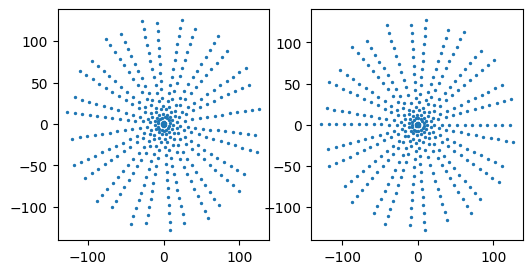

In [5]:
# ------------------------------------------------------- # 
# Exploración de los datos 
# ------------------------------------------------------- # 

# Visualizar las trayectorias 

selected_frame_1 = 21
selected_frame_2 = 3

plt.figure(figsize=(6,3))
read_out_jump = 10 # mostrar 1 de cada 10 puntos de read out 
plt.subplot(121)
plt.scatter(
    radial_acquisition.trajs[selected_frame_1, :, ::read_out_jump, 0],
    radial_acquisition.trajs[selected_frame_1, :, ::read_out_jump, 1],
    s=2
)
plt.subplot(122)
plt.scatter(
    radial_acquisition.trajs[selected_frame_2, :, ::read_out_jump, 0],
    radial_acquisition.trajs[selected_frame_2, :, ::read_out_jump, 1],
    s=2
)

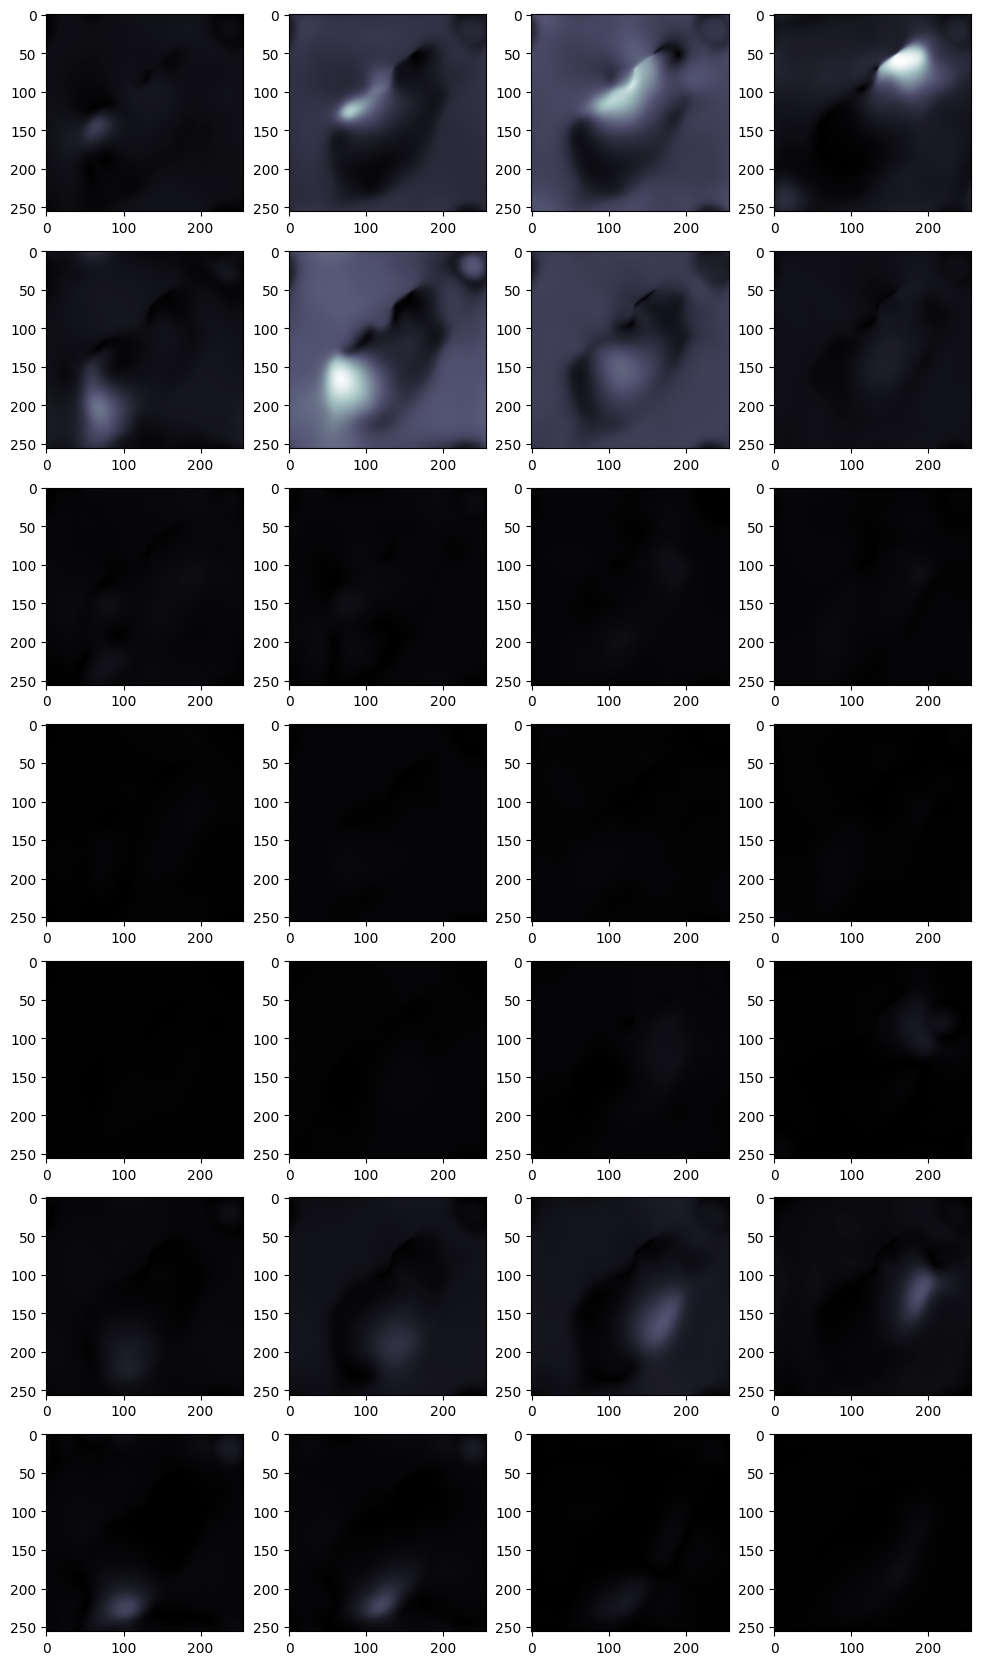

In [6]:
# Visualizar las bobinas (en la misma escala) 

plt.figure(figsize=(4*3, 7*3))
for i in range(28):
    plt.subplot(7,4,i+1)
    plt.imshow(np.abs(csmap[i]), vmax=np.abs(csmap).max(), cmap='bone')

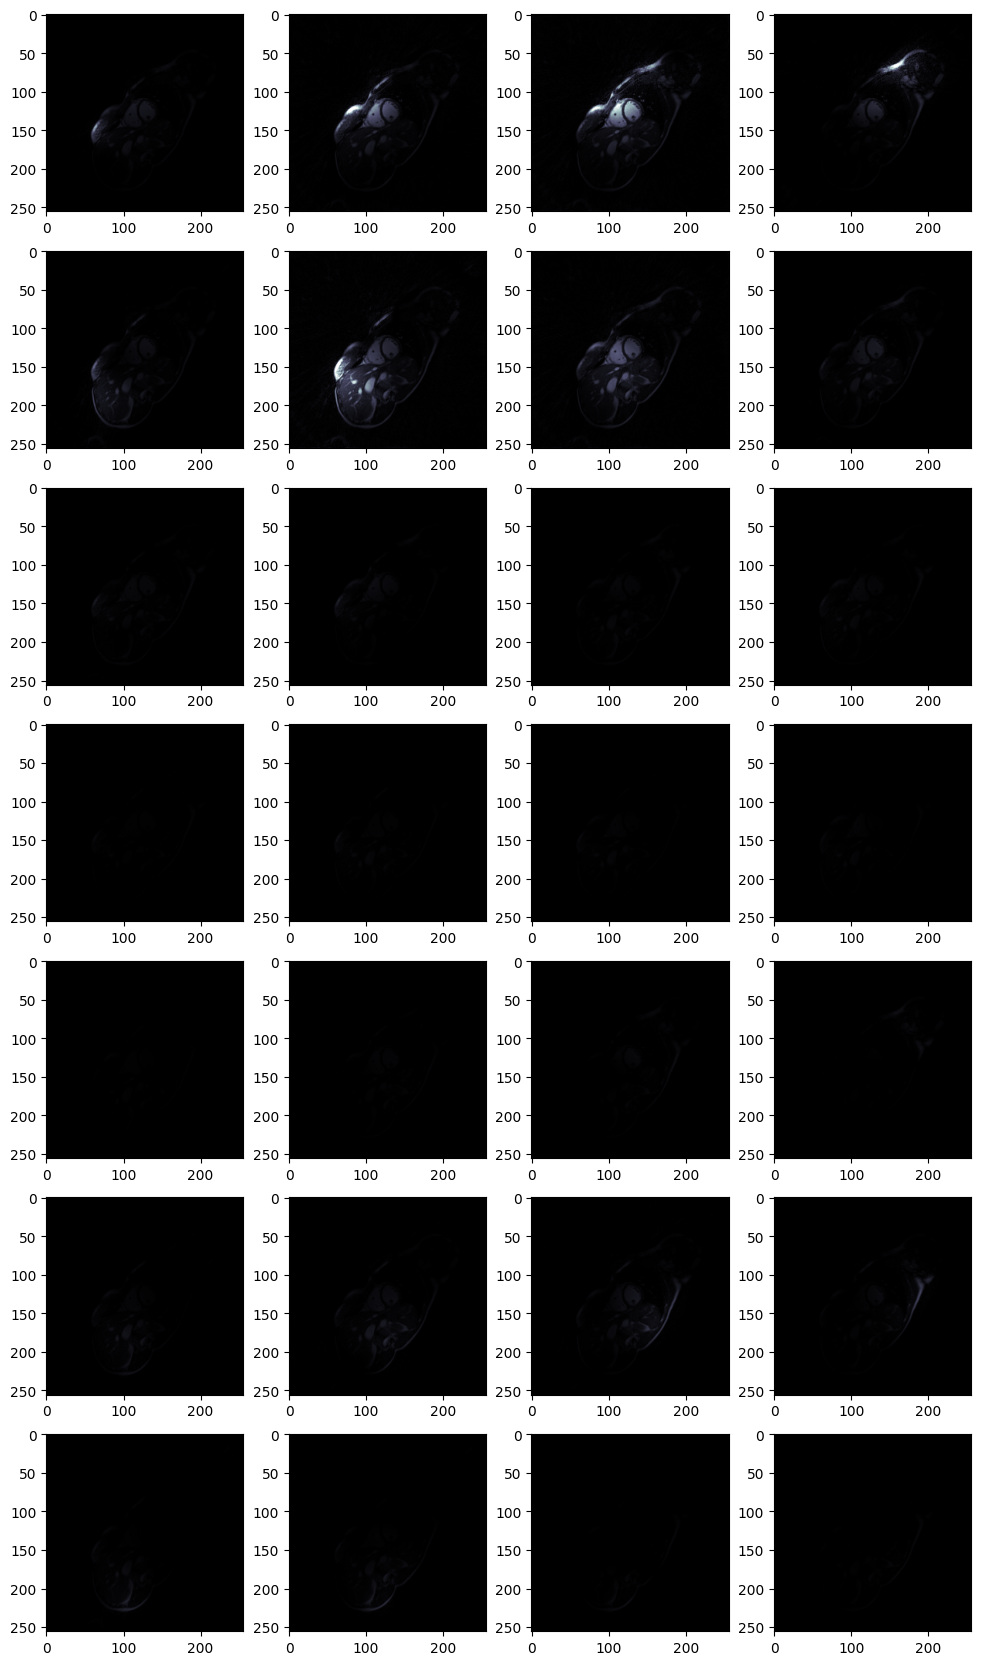

In [7]:
# Visualizar la imagen "sensitivity weighted" (pesada por las bobinas)

selected_frame = 8 
plt.figure(figsize=(4*3, 7*3))
for i in range(28):
    plt.subplot(7,4,i+1)
    plt.imshow(np.abs(reco_grasp[...,selected_frame] * csmap[i]), vmax=np.abs(reco_grasp).max(), cmap='bone')


Text(0.5, 1.0, 'GRASP')

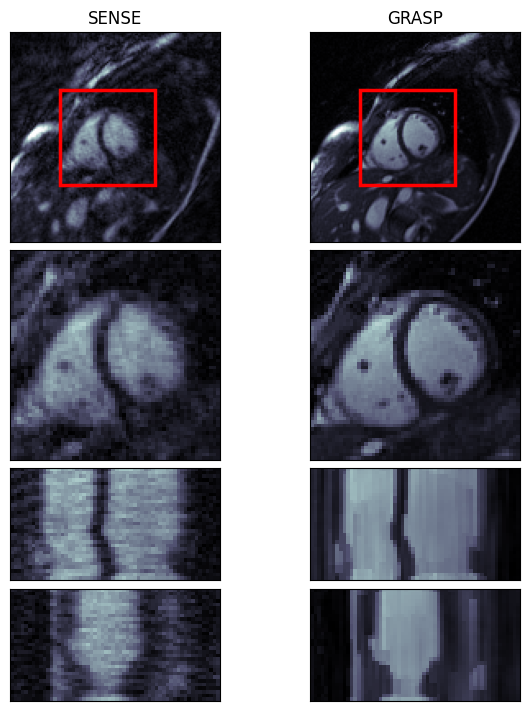

In [8]:
# Visualizar los perfiles temporales x-t de una imagen, en una zona cropeada 

from inrmri.basic_plotting import full_halph_FOV_space_time 
from inrmri.image_processor import reduce_FOV 

fig, axs = full_halph_FOV_space_time([reduce_FOV(reco_sense), reduce_FOV(reco_grasp)], crop_ns=[35,35,30,40], saturation=0.7, frame=10)
axs[0,0].set_title('SENSE')
axs[1,0].set_title('GRASP')

### Preparación de datos para entrenamiento

In [ ]:
from jax import jit, vmap, random
import jax.numpy as np
import optax

# Imports del paquete inrmri
from inrmri.radon import calculate_angle
from inrmri.new_radon import ForwardRadonOperator
from inrmri.utils import is_inside_of_radial_lim, meshgrid_from_subdiv_autolims
from inrmri.radial_acquisitions import kFOV_limit_from_spoke_traj, check_correct_dataset
from inrmri.basic_nn import weighted_loss
from inrmri.advanced_training import train_with_updates, OptimizerWithExtraState

# -------------------------------------------------------------------
# Inicialización de claves aleatorias
# -------------------------------------------------------------------
key = random.PRNGKey(0)
key_net, key_params, key_train = random.split(key, 3)  # reproducibilidad

# -------------------------------------------------------------------
# Creación del dataset
# -------------------------------------------------------------------
print("Creating dataset...")
train_X, train_Y = radial_acquisition.generate_dataset()

# Escalado de la señal para mantener un orden de magnitud adecuado
train_Y = 100 * train_Y

# Nota: la función load_data está pensada para trabajar con INRs.
# Aquí se aplica procesamiento adicional a train_X y train_Y.
# Ejemplo alternativo:
# train_X, train_Y, csmap, _, hollow_mask = load_data(config_data)

# -------------------------------------------------------------------
# Chequeo de las trayectorias
# -------------------------------------------------------------------
check_correct_dataset(train_X)

# Cálculo del límite de FOV a partir de un spoke de ejemplo
spoke_limit = kFOV_limit_from_spoke_traj(train_X[0, 1:, :])

# Escalamiento inicial
scaling_param = 1.0

# -------------------------------------------------------------------
# Preprocesamiento de entradas
# -------------------------------------------------------------------
# Ángulos de cada spoke (excluyendo el primer punto = tiempo)
angles = vmap(calculate_angle)(train_X[:, 1:])

# Tiempos asociados a cada frame (almacenados en el primer punto de cada spoke)
times = train_X[:, 0, 0]

# Nueva representación de entradas: (angle, time)
train_X = np.stack([angles, times], axis=-1)

Creating dataset...
The trajectories are centered


In [10]:
# -------------------------------------------------------------------
# Configuración inicial
# -------------------------------------------------------------------
gtim = reco_grasp
NFRAMES = gtim.shape[-1]          # número de frames dinámicos
IMSHAPE = gtim.shape[:2]          # dimensiones espaciales (px, py)
N = IMSHAPE[0]                    # dimensión lateral (asumiendo cuadrado)

# Operador de Radon y grilla espacial
radon_operator = ForwardRadonOperator(csmap, spoke_limit)
grid = meshgrid_from_subdiv_autolims(IMSHAPE)

In [ ]:
# -------------------------------------------------------------------
# Post-procesamiento de reconstrucciones
# -------------------------------------------------------------------
def post_processing(im):
    """
    Aplica una máscara espacial para limitar la reconstrucción
    al dominio válido definido por la adquisición radial.

    Parameters
    ----------
    im : np.ndarray
        Imagen reconstruida.
        Forma: (px, py, nframes)

    Returns
    -------
    np.ndarray
        Imagen postprocesada, con voxeles fuera del FOV puestos en cero.
    """
    # Calcula la máscara booleana de puntos dentro del límite radial
    inside_mask = is_inside_of_radial_lim(grid, 1.0) #radio 1

    # Expande la máscara a lo largo de la dimensión temporal
    return im * inside_mask[:, :, None]

In [ ]:
from inrmri.dip.tddip import TimeDependant_DIP_Net, helix_generator

# Grid temporal normalizado (0 a 1, excluyendo el endpoint)
ts = np.linspace(0, 1, gtim.shape[-1], endpoint=False)

# Definición del modelo Time-Dependent DIP
net = TimeDependant_DIP_Net(
    nframes=NFRAMES,             # número de frames temporales
    total_cycles=1,              # número de ciclos en la parametrización temporal
    latent_generator=helix_generator,  # generador de la latente (ej. hélice)
    imshape=IMSHAPE,             # forma espacial de la imagen (nx, ny)
    mapnet_layers=[64, 64],      # capas ocultas de MapNet
    cnn_latent_shape=(8, 8),     # forma de la grilla latente para el decoder
    features=64,                 # número de features en el decoder
    levels=4,                    # niveles jerárquicos en el decoder
    out_images=1                 # número de imágenes de salida (ej. magnitud)
)

# Inicialización de parámetros
params = net.init_params(key_params)

(1,) (8, 8) (64,)
(1,) (16, 16) (64,)
(1,) (32, 32) (64,)
(1,) (64, 64) (64,)
(1,) (128, 128) (64,)


In [15]:
from inrmri.new_radon import get_weight_freqs

# Pesos de frecuencia en k-space (para la pérdida ponderada)
WEIGHT_FREQS = get_weight_freqs(N)

def loss(params, X, Y, key):
    """
    Calcula la función de pérdida para el entrenamiento del modelo Time-Dependent DIP.

    Parameters
    ----------
    params : PyTree
        Parámetros actuales de la red neuronal.
    X : np.ndarray
        Datos de entrada de forma (batch, 2), donde:
        - X[:, 0] = ángulos de muestreo (alphas).
        - X[:, 1] = tiempos normalizados en [0,1).
    Y : np.ndarray
        Datos medidos en k-space (ground truth).
        Forma esperada: (batch, n_coils, N, 1).
    key : jax.random.PRNGKey
        Clave aleatoria para operaciones estocásticas (ej. dropout).

    Returns
    -------
    loss_value : float
        Valor escalar de la pérdida ponderada.
    updates : dict
        Actualizaciones del estado interno de la red (ej. batch_stats).
    """
    # Separar ángulos y tiempos
    alphas, times = X[:, 0], X[:, 1]

    # Convertir tiempos normalizados en índices de frame
    t_idx = np.int32(times * NFRAMES)

    # Paso forward de la red: reconstrucción de imágenes dependientes del tiempo
    pred_images, updates = net.train_forward_pass(params, key, t_idx)  # (batch, n, n, 1)
    pred_images = pred_images[..., 0]  # quitar la dimensión extra de canales → (batch, n, n)

    # Aplicar operador de Radon con ponderación de sensibilidad de coils
    rotated_im = radon_operator.rotated_csweighted_ims(pred_images, alphas)   # (batch, n_coils, N)
    spoke_radon_kspace = radon_operator.radon_transform(rotated_im)          # (batch, n_coils, N)

    # Ground truth: quitar dimensión extra en Y
    target_kspace = Y[..., 0]  # (batch, n_coils, N)

    # Debug opcional de shapes
    print("shapes: spoke ", spoke_radon_kspace.shape, " , target ", target_kspace.shape)

    # Cálculo de la pérdida ponderada en frecuencia
    loss_value = weighted_loss(
        spoke_radon_kspace,
        target_kspace,
        (1. + WEIGHT_FREQS)[None, None, :]
    )

    return loss_value, updates


In [16]:
# -------------------------------------------------------------------
# Configuración de entrenamiento
# -------------------------------------------------------------------
learning_rate = 1e-3
optimizer = OptimizerWithExtraState(
    optax.adam(learning_rate)    # optimizador Adam con estado extra
)

# Número total de miles de iteraciones (kiter → kilo-iteraciones)
total_kiter = 1   # equivale a 1000 iteraciones reales

config_training = {
    "learning_rate": learning_rate,
    "total_kiter": total_kiter,
    "key_train": key_train,
}

# -------------------------------------------------------------------
# Entrenamiento
# -------------------------------------------------------------------
results = train_with_updates(
    jit(loss),             # función de pérdida jit-optimizada
    train_X,               # entradas (ángulos + tiempos)
    train_Y,               # ground truth en k-space
    params,                # parámetros iniciales de la red
    optimizer,             # optimizador Adam
    key_train,             # clave aleatoria para dropout / variabilidad
    nIter=total_kiter * 1000 + 1,  # número total de iteraciones
    batch_size=3           # tamaño del batch de entrenamiento
)


train iter:   0%|          | 0/1001 [00:00<?, ?it/s]

(3,) (8, 8) (64,)
(3,) (16, 16) (64,)
(3,) (32, 32) (64,)
(3,) (64, 64) (64,)
(3,) (128, 128) (64,)
256
shapes: spoke  (3, 28, 256)  , target  (3, 28, 256)


train iter:   0%|          | 1/1001 [00:08<2:23:11,  8.59s/it]

 it 0, train loss = 8.138527e-01
(3,) (8, 8) (64,)
(3,) (16, 16) (64,)
(3,) (32, 32) (64,)
(3,) (64, 64) (64,)
(3,) (128, 128) (64,)
shapes: spoke  (3, 28, 256)  , target  (3, 28, 256)


train iter:  10%|█         | 101/1001 [01:54<16:29,  1.10s/it]

 it 100, train loss = 4.495078e-01


train iter:  20%|██        | 201/1001 [03:38<13:50,  1.04s/it]

 it 200, train loss = 4.140137e-01


train iter:  30%|███       | 301/1001 [05:21<12:21,  1.06s/it]

 it 300, train loss = 4.477223e-01


train iter:  40%|████      | 401/1001 [07:07<10:32,  1.05s/it]

 it 400, train loss = 4.459975e-01


train iter:  50%|█████     | 501/1001 [08:53<08:37,  1.03s/it]

 it 500, train loss = 4.273255e-01


train iter:  60%|██████    | 601/1001 [10:33<06:37,  1.01it/s]

 it 600, train loss = 3.243668e-01


train iter:  70%|███████   | 701/1001 [12:12<05:26,  1.09s/it]

 it 700, train loss = 3.933825e-01


train iter:  80%|████████  | 801/1001 [13:51<03:33,  1.07s/it]

 it 800, train loss = 3.609780e-01


train iter:  90%|█████████ | 901/1001 [15:33<01:38,  1.01it/s]

 it 900, train loss = 4.253478e-01


train iter: 100%|██████████| 1001/1001 [17:06<00:00,  1.03s/it]

 it 1000, train loss = 3.360336e-01


In [19]:
# %% Examining results

# -------------------------------------------------------------------
# Recuperar parámetros entrenados
# -------------------------------------------------------------------
final_param = results["param_history"][f"param-{total_kiter}"]

# -------------------------------------------------------------------
# Reconstrucción cine (imágenes dinámicas)
# -------------------------------------------------------------------
# Evaluamos la red en todos los frames [0 .. NFRAMES-1]
# usando batches de 5 tiempos por iteración
predim = net.lax_cine(
    final_param,
    key,
    np.arange(NFRAMES),  # todos los índices de tiempo
    batch=5
)

(5,) (8, 8) (64,)
(5,) (16, 16) (64,)
(5,) (32, 32) (64,)
(5,) (64, 64) (64,)
(5,) (128, 128) (64,)


In [27]:
# -------------------------------------------------------------------
# Post-procesamiento
# -------------------------------------------------------------------
# Se aplica la máscara espacial y se normaliza a [0,1] por magnitud
predim = post_processing(predim) / np.abs(predim).max() 

print("Reconstrucción final: ", predim.shape)

Reconstrucción final:  (256, 256, 31)


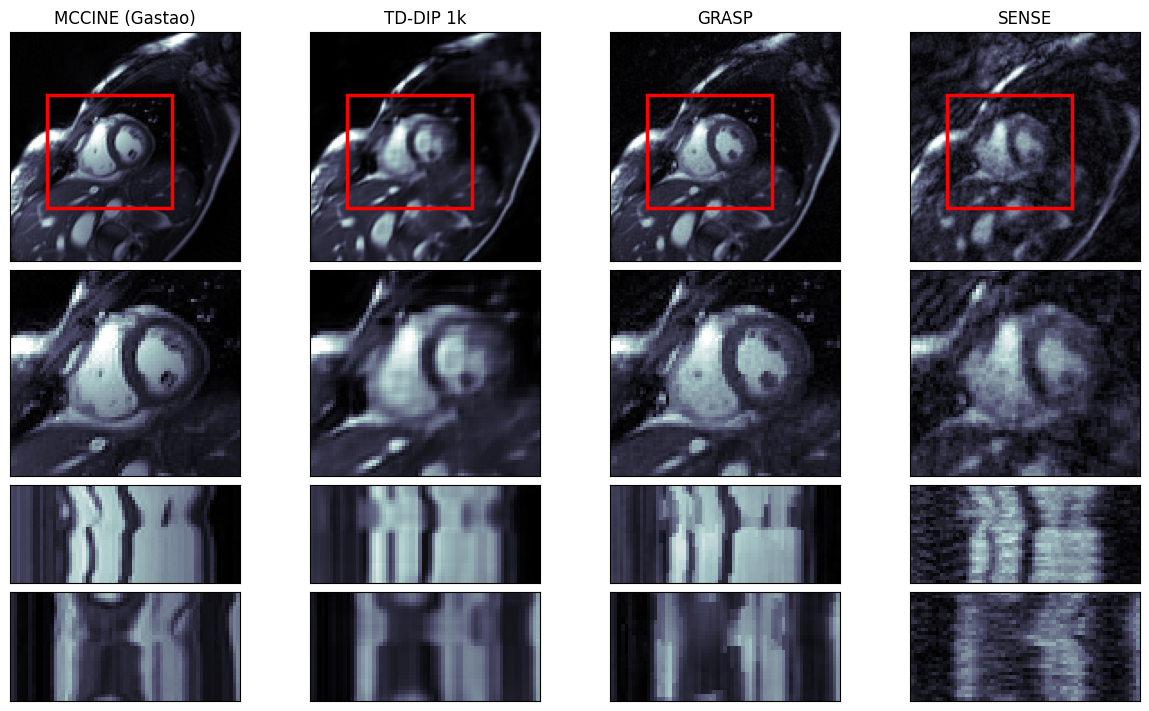

In [ ]:
from inrmri.basic_plotting import full_halph_FOV_space_time
from inrmri.image_processor import BeforeLinRegNormalizer, reduce_crop_abs
import matplotlib.pyplot as plt 

crop_ns = [35,30,20,38]
gtim = np.load(folder + 'sl5-reco-reference.npy') # 
improc = BeforeLinRegNormalizer(gtim, [0,0,0,0]) # normaliza todas las imagenes a la escala de gtim 

gt_proc = improc.process(gtim)

def final_processing(im):
    im = improc.process(im)
    im = onp.roll(im, 15, axis=-1) # 15 es el argmin del error con gastao luego de probar todos los rolls 
    return im 

# el [1:] es porque gtim solo tiene 30 frames (no 31)
pred_proc = final_processing(predim[...,1:]) 
sense_proc = final_processing(reco_sense[...,1:])
grasp_proc = final_processing(reco_grasp[...,1:])

frame = 8 # 8, 23 
vmax = np.abs(gtim).max()
recos = [gt_proc, pred_proc, grasp_proc, sense_proc]
titles = ['MCCINE (Gastao)', f'TD-DIP {total_kiter}k', 'GRASP', 'SENSE']
fig, axs = full_halph_FOV_space_time(recos, crop_ns, frame = frame,saturation=0.5, vmax=vmax)
for ax, title in zip(axs, titles):
    ax[0].set_title(title)